<a href="https://colab.research.google.com/github/MartinPdeS/FlowCyPy/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# We have to go through custom install because of Colab vs pandas version conflict
!pip install numpy>=2.0.0
!pip install pandas==2.3.0
!pip install PyMieSim
!pip install FlowCyPy==0.34.0 --no-cache-dir --quiet --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 13.0 MB/s eta 0:00:00


In [1]:
import FlowCyPy

print(FlowCyPy.__version__)

0.34.0


In [2]:
import numpy as np

from TypedUnit import ureg

In [3]:
from FlowCyPy import SimulationSettings

SimulationSettings.include_noises = True
SimulationSettings.include_shot_noise = True
SimulationSettings.include_dark_current_noise = True
SimulationSettings.include_source_noise = True
SimulationSettings.include_amplifier_noise = True
SimulationSettings.assume_perfect_hydrodynamic_focusing = True
SimulationSettings.population_cutoff_bypass = False

Fluidics
--------

In [11]:
from FlowCyPy.fluidics import (
    FlowCell,
    Fluidics,
    ScattererCollection,
    population,
)
from FlowCyPy.fluidics import distributions

flow_cell = FlowCell(
    sample_volume_flow=80 * ureg.microliter / ureg.minute,
    sheath_volume_flow=1 * ureg.milliliter / ureg.minute,
    width=200 * ureg.micrometer,
    height=100 * ureg.micrometer,
)

scatterer_collection = ScattererCollection()

ri_distribution = distributions.Normal(
    mean=1.44 * ureg.RIU,
    standard_deviation=0.002 * ureg.RIU
)

diameter_distribution = distributions.RosinRammler(
    scale=150 * ureg.nanometer,
    shape=30 * ureg.nanometer
)

population_0 = population.Sphere(
    name="Pop: 150nm",
    concentration=5e9 * ureg.particle / ureg.milliliter,
    refractive_index=ri_distribution,
    diameter=diameter_distribution,
    medium_refractive_index=1.33 * ureg.RIU
)

diameter_distribution = distributions.RosinRammler(
    scale=200 * ureg.nanometer,
    shape=30 * ureg.nanometer
)

population_1 = population.Sphere(
    name="Pop: 200nm",
    concentration=5e9 * ureg.particle / ureg.milliliter,
    diameter=diameter_distribution,
    refractive_index=ri_distribution,
    medium_refractive_index=1.33 * ureg.RIU
)


scatterer_collection.add_population(population_0, population_1)

scatterer_collection.dilute(factor=80)

fluidics = Fluidics(scatterer_collection=scatterer_collection, flow_cell=flow_cell)

Opto-Electronics
----------------

In [12]:
from FlowCyPy.opto_electronics import (
    Detector,
    OptoElectronics,
    TransimpedanceAmplifier,
    source,
)

source = source.GaussianBeam(
    numerical_aperture=0.1 * ureg.AU,
    wavelength=450 * ureg.nanometer,
    optical_power=200 * ureg.milliwatt,
    RIN=-140,
)


detector_forward = Detector(
    name="forward",
    phi_angle=0 * ureg.degree,
    numerical_aperture=0.3 * ureg.AU,
    responsivity=1 * ureg.ampere / ureg.watt,
)

detector_side = Detector(
    name="side",
    phi_angle=90 * ureg.degree,
    numerical_aperture=0.3 * ureg.AU,
    responsivity=1 * ureg.ampere / ureg.watt,
)


amplifier = TransimpedanceAmplifier(
    gain=10 * ureg.volt / ureg.ampere,
    bandwidth=10 * ureg.megahertz,
    voltage_noise_density=0.1 * ureg.nanovolt / ureg.sqrt_hertz,
    current_noise_density=0.2 * ureg.femtoampere / ureg.sqrt_hertz,
)

opto_electronics = OptoElectronics(
    detectors=[detector_forward, detector_side], source=source, amplifier=amplifier
)

Signal Processing
-----------------

In [13]:
from FlowCyPy.signal_processing import (
    Digitizer,
    SignalProcessing,
    circuits,
    peak_locator,
    triggering_system,
)

analog_processing = [
    circuits.BaselineRestorator(window_size=10 * ureg.microsecond),
    circuits.BesselLowPass(cutoff=2 * ureg.megahertz, order=4, gain=2),
]

digitizer = Digitizer(
    bit_depth="14bit", saturation_levels="auto", sampling_rate=60 * ureg.megahertz
)

_triggering_system = triggering_system.DynamicWindow(
    trigger_detector_name="forward",
    threshold=10 * ureg.microvolt,
    pre_buffer=20,
    post_buffer=20,
    max_triggers=-1,
)

peak_algorithm = peak_locator.GlobalPeakLocator(compute_width=False)

signal_processing = SignalProcessing(
    digitizer=digitizer,
    analog_processing=analog_processing,
    triggering_system=_triggering_system,
    peak_algorithm=peak_algorithm,
)

Flow Cytometer
--------------

In [14]:
from FlowCyPy import FlowCytometer

cytometer = FlowCytometer(
    opto_electronics=opto_electronics,
    fluidics=fluidics,
    signal_processing=signal_processing,
    background_power=0.001 * ureg.milliwatt,
)

results = cytometer.run(run_time=2 * ureg.millisecond)

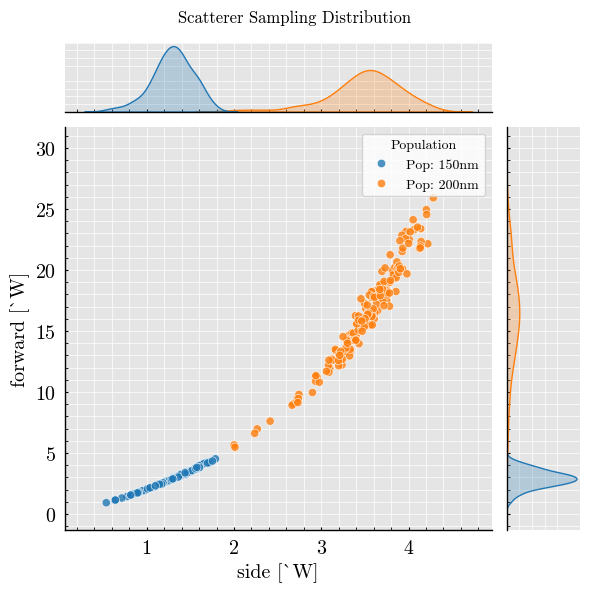

In [17]:
_ = results.event_collection.plot(x="side", y="forward")

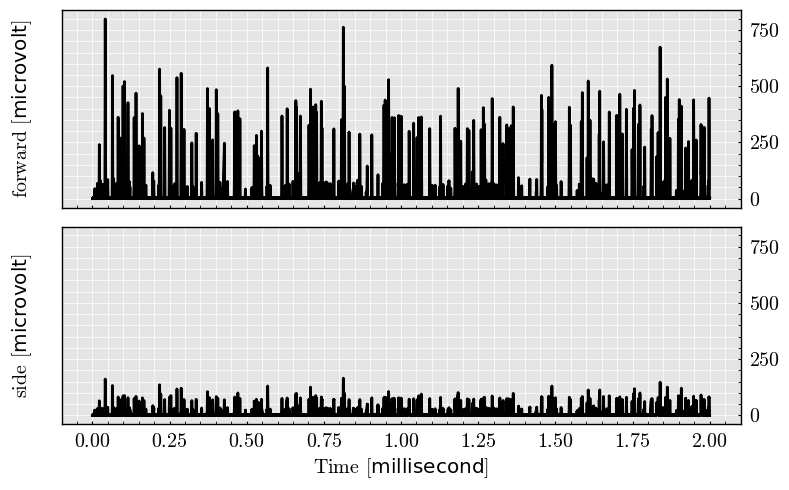

In [21]:
_ = results.signal.analog.plot()

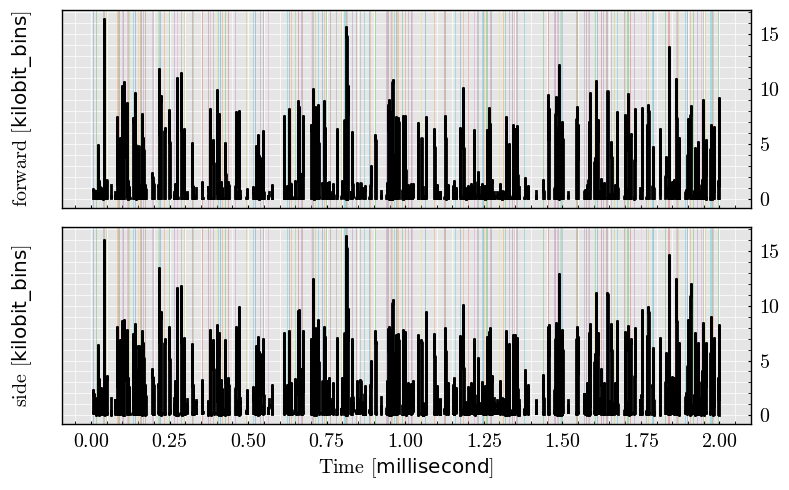

In [22]:
_ = results.signal.digital.plot()

Classifier
----------

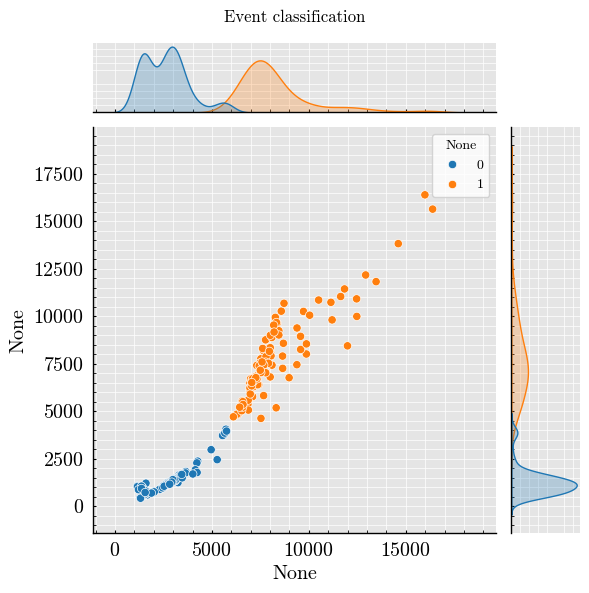

In [25]:
from FlowCyPy.classifier import KmeansClassifier

classifier = KmeansClassifier(number_of_clusters=2)

classified_df = classifier.run(
    dataframe=results.peaks.unstack("Detector"),
    features=["Height"],
    detectors=["side", "forward"],
)

_ = classified_df.plot(x=("side", "Height"), y=("forward", "Height"))